# Random Forest Classifier with TF-IDF Encodings

Sources:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# Pre-processing

Imports and loading dataset

In [ ]:
import pandas as pd
import nltk
import seaborn as sns
import re
import numpy as np
import warnings
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
df = pd.read_csv('train1_full.csv') 
df.head()

In [ ]:
# Here we get transform the documents into sentences for the word2vecmodel
def preprocess(df):
    df['comment_text'] = df.comment_text.str.lower()
    df['document_sentences'] = df.comment_text.str.split('.') 
    df['tokenized_sentences'] = list(map(lambda sentences: list(map(nltk.word_tokenize, sentences)), df.document_sentences))  
    df['tokenized_sentences'] = list(map(lambda sentences: list(filter(lambda lst: lst, sentences)), df.tokenized_sentences))

preprocess(df)

Split data into training and test sets

In [ ]:
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(df.drop(columns='label'), df['label'], test_size=.2)

In [ ]:
def remove_items(test_list, item):
    # utility function to remove stop words
    for i in test_list:
        if(i == item):
            test_list.remove(i)
  
    return test_list

In [ ]:
def preprocess_text(sen):
    sentence = sen.lower()
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Remove extra spaces
    sentence = re.sub(' +', ' ', sentence)
    sentence_list = sentence.split()

    # Removing stop words
    stop_words = ['u', 'ur', 'im', 'can', 'cant', 'i', 'me', 'my', 'myself', 'we', 'go', 'our', 'ours', 'ourselves', 'you', "youre", "youve", "youll", "youd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "thatll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "shouldve", 'now', 'd', 'll', 'm', 'o', 're', 'r', 'ur', 've', 'y', 'ain', 'aren', "arent", 'couldn', "couldnt", 'didn', "didnt", 'doesn', "doesnt", 'hadn', "hadnt", 'hasn', "hasnt", 'haven', "havent", 'isn', "isnt", 'ma', 'mightn', "mightnt", 'mustn', "mustnt", 'needn', "neednt", 'shan', "shant", 'shouldn', "shouldnt", 'wasn', "wasnt", 'weren', "werent", 'won', "wont", 'wouldn', "wouldnt"]
    for stop_word in stop_words:
      if stop_word in sentence_list:
        sentence_list = remove_items(sentence_list, stop_word)

    # Join back to list
    sentence = " ".join(sentence_list)

    # Remove extra spaces
    sentence = re.sub(' +', ' ', sentence)
    return sentence.lstrip()

Get a list of all messages and labels

In [ ]:
X_train = []
sentences = list(train["comment_text"])
for sen in sentences:
    X_train.append(preprocess_text(sen))

In [ ]:
X_test = []
sentences1 = list(test["comment_text"])
for sen in sentences1:
    X_test.append(preprocess_text(sen))

In [ ]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X_train_matrix = vectorizer.fit_transform(X_train)
X_test_matrix = vectorizer.transform(X_test)

# Random Forest

In [ ]:
# Gini
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_matrix, y_train)
rf_preds = rf.predict(X_test_matrix)

In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics
print(classification_report(y_test, rf_preds))
print(confusion_matrix(y_test, rf_preds))

In [ ]:
# Entropy (information gain)
rf_e = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf_e.fit(X_train_matrix, y_train)
rf_e_preds = rf_e.predict(X_test_matrix)

In [ ]:
pred_count = np.zeros(np.max(rf_e_preds + 1))
for i in range(0, np.max(rf_e_preds) + 1): 
  pred_count[i] = np.sum(rf_e_preds == i)
  #print("Predicted " + str(i) + ": " + str(int(pred_count[i])))

incorrect_pred = np.argwhere(y_test != rf_e_preds)

In [ ]:
print(classification_report(y_test, rf_e_preds))
print(confusion_matrix(y_test, rf_e_preds))

In [ ]:
# Entropy (information gain)
rf_e2 = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=32)
rf_e2.fit(X_train_matrix, y_train)
rf_e2_preds = rf_e2.predict(X_test_matrix)

print(classification_report(y_test, rf_e2_preds))
print(confusion_matrix(y_test, rf_e2_preds))

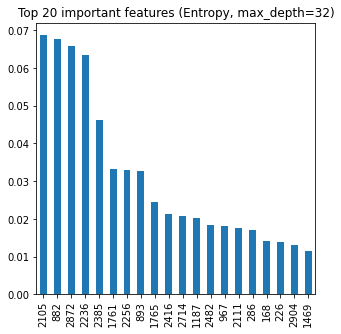

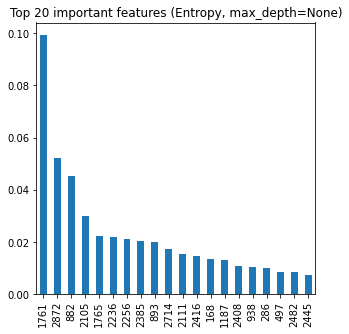

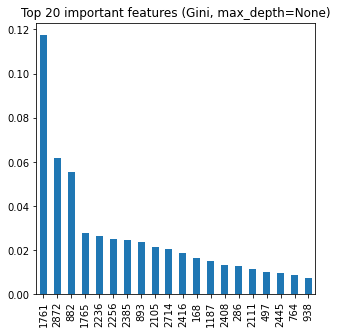

In [ ]:
feat_importances = pd.Series(rf_e2.feature_importances_)
feat_importances.nlargest(20).plot(kind='bar',figsize=(5,5))
plt.title("Top 20 important features (Entropy, max_depth=32)")
plt.show()

feat_importances = pd.Series(rf_e.feature_importances_)
feat_importances.nlargest(20).plot(kind='bar',figsize=(5,5))
plt.title("Top 20 important features (Entropy, max_depth=None)")
plt.show()

feat_importances = pd.Series(rf.feature_importances_)
feat_importances.nlargest(20).plot(kind='bar',figsize=(5,5))
plt.title("Top 20 important features (Gini, max_depth=None)")
plt.show()